# Logistic Regression - Newton's Method

In this notebook, I implement Newton's Method in order to minimize the empirical loss function $J(\theta)$ for logistic regression given below:

\begin{equation*}
J(\theta) = -\frac{1}{m} \sum_{i=1}^m \log{h_{\theta}(y^{(i)}x^{(i)}})  
\quad\quad \text{where  $y^{(i)} \in \{-1,1\},\quad $ $h_{\theta}(x) = \frac{1}{1+e^{-y\theta^T x}}$}
\end{equation*}

The basic approach of Newton's method is to perform the following update rule on a parameter $\theta$ in order to maximize the logistic regression log -likelihood function $l(\theta)$:

\begin{equation*}
\theta := \theta - \frac{l'(\theta)}{l''(\theta)} 
\end{equation*}

However, in the multi-dimensional case, since $\theta$ is a **vector**, the method can be generalized using the Hessian matrix $H$:

\begin{equation*}
\theta := \theta - H^{-1} \nabla_{\theta}l(\theta) 
\end{equation*}

We will play around with this algorithm using data from the first problem-set of Andrew Ng's popular machine-learning course **CS229**. For more information, visit http://cs229.stanford.edu/. 
 
**Please note** that this is a practice implementation only. It does not include more advanced features such as regularization and is not optimized for speed. 


### Exploratory Data Analysis

Let's import the data from the CS229 website and create binary scatter-plot.

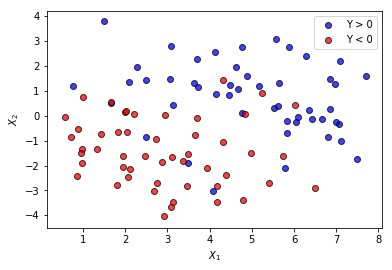

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Import data into pandas
x_url = 'http://cs229.stanford.edu/ps/ps1/logistic_x.txt'
y_url = 'http://cs229.stanford.edu/ps/ps1/logistic_y.txt'

x = pd.read_csv(x_url, sep="\s+", names=['$X_1$','$X_2$'])
y = pd.read_csv(y_url, names = 'Y')

data = pd.concat([x,y],axis=1)

# Create binary scatter-plot of data
condition = data['Y'] > 0
subset_1 = data[condition]
subset_2 = data[~condition]

plt.scatter(subset_1['$X_1$'],subset_1['$X_2$'], c='b', alpha=0.75, edgecolors='k', label='Y > 0')
plt.scatter(subset_2['$X_1$'],subset_2['$X_2$'], c='r', alpha=0.75, edgecolors='k', label='Y < 0')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.show()



Looking at the scatter-plot above, we can note several features that support our decision to use a logistic regression model:
   1. The data looks reasonably linearly separable.
   2. Same number of labels and features
   3. No significant outliers for each label
   4. Small number of features 

### Applying Newton's Method

First, we need to separately compute $\nabla_{\theta}l(\theta)$ and $H^{-1}$. Then we apply the update rule to $\theta$. In this case, $l(\theta)$ is equivalent to our cost function $J(\theta)$.

In [257]:
# Define the functions used for applying Newton's Method

def cost_gradient(m, theta, x, y):
    '''Computes the gradients of the log-likelihood function w.r.t to each parameter
    
        Parameters
        ----------
        theta: np.array
            Numpy array of parameter values
        x: np.array
            Numpy array of data
        y: np.array
            Numpy array of response labels
        
        Returns
        -------
        gradient: np.array
            Numpy array of gradients w.r.t each parameter
            
    '''
    gradient = np.zeros(len(theta))
    
    for i in range(0,len(theta)):
        gradient[i] = (-1/m)*sum((sigmoid(theta, x, -y))*y[:,0]*x[:,i])
        
    return gradient
    
def inverse_hessian(n, theta, x, y):
    '''Computes the Inverse of the Hessian of the log-likelihood function
        
        Parameters
        ----------
        n: int
            Integer of length of parameter vector including intercept term
        theta: np.array
            Numpy array of parameter values
        x: np.array
            Numpy array of data
        y: np.array
            Numpy array of response labels
            
        Returns
        -------
        inv_hessian: np.array
            Numpy array of inverted Hessian matrix
    '''
    hessian = np.zeros((n+1,n+1))

    for i in range(0,n+1):
        for j in range(0,n+1):
            hessian[i,j] = (1/m)*sum(sigmoid(theta, x, y)*(1-sigmoid(theta, x, y))*x[:,i]*x[:,j])
    
    inv_hessian = np.linalg.inv(hessian)
    
    return inv_hessian

def fisher(theta, gradient, inv_hessian):
    '''Applies Fisher's scoring algorithm to update the parameter vector theta

        Parameters
        ----------
        theta: np.array
            Numpy array of parameter vector
        gradient: np.array
            Numpy array of gradients w.r.t. parameters
        inv_hessian: np.array
            Numpy array of inverse hessian w.r.t. parameters
        Returns
        -------
        theta: np.array
            Numpy array of updated parameter vector
    '''  
    theta = theta - inv_hessian.dot(gradient)
    
    return theta
    

def sigmoid(theta, x, y):
    '''Compute the sigmoid of a parameter vector, data matrix, and the reponse labels
    
        Parameters
        ----------
        theta: np.array
            Numpy array of parameter values
        x: np.array
            Numpy array of data
        y: np.array
            Numpy array of response labels
            
        Returns
        -------
        sigmoid: np.array
            Numpy array of sigmoid values
    '''
    sigmoid = 1/(1+ np.exp(-y[:,0]*x.dot(theta)))
    
    return sigmoid

In [258]:
# Applying Newtons Method using the functions above. Additionally, we will benchmark the algorithm.

# Setup the data matrices and the parameter vector
[m, n] = np.shape(x)

# Add the intercept term to the data 
x = np.column_stack((np.ones(m),x.values))
y = y.values

# Initialize theta vector
theta = np.zeros(n+1)

# Run Newton's Method.
n_iter = 50

start = time.time()
cost_array = np.zeros(n_iter)

for i in range(0,n_iter):
    gradient = cost_gradient(m, theta, x, y)
    inv_hessian = inverse_hessian(n, theta, x, y)
    
    theta = fisher(theta, gradient, inv_hessian)
    cost_array[i] = (-1/m)*sum(np.log(sigmoid(theta, x, y)))

end = time.time() 
print('%f iterations completed in: %f secs' %(n_iter, end-start))


50.000000 iterations completed in: 0.079765 secs


### Evaluation Metrics

Next, we will plot the cost function versus the number of iterations in order to get a sense of the convergence rate. Additionally, we will plot the decision boundary to see how well it partitions the data.

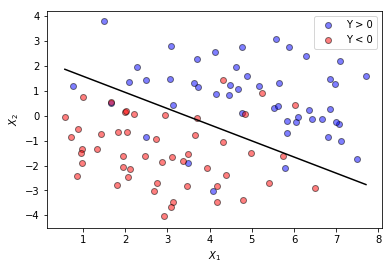

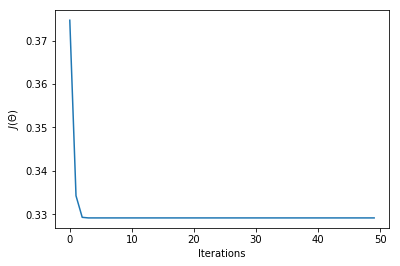

In [276]:
# Plot the decision boundary
x1 = np.linspace(min(x[:,1]),max(x[:,1]),100)
x2 = -(theta[1]/theta[2])*x1 - (theta[0]/theta[2])

plt.scatter(subset_1['$X_1$'],subset_1['$X_2$'], c='b', alpha=0.5, edgecolors='k', label='Y > 0')
plt.scatter(subset_2['$X_1$'],subset_2['$X_2$'], c='r', alpha=0.5, edgecolors='k', label='Y < 0')
plt.plot(x1,x2,'k')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.show()

# Plot the converge rate (cost-function gradient vs. iterations)
plt.plot(cost_array)
plt.xlabel('Iterations')
plt.ylabel('$J(\Theta)$')
plt.show()

The decision boundary looks pretty good given that we are not performing any regularization. Additionally, we can note that the converge rate using Newton's method is extremely fast (only 3 iterations) before reaching the optimal decision boundary.